In [ ]:
import numpy as np
import cv2
import os
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.losses import MeanSquaredError
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dense, Add, Reshape, PReLU, UpSampling2D, Lambda, LeakyReLU, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
import glob
import random
from numpy import asarray
from itertools import repeat
import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.11.0
Keras version 2.11.0


## Resizing the images to 128x128 and 32x32 to feed into the SRGAN

In [16]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

In [17]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Conv2D, UpSampling2D, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
import keras.backend as K

In [ ]:
def build_generator(input_shape):
    input_low_res = Input(shape=input_shape)
    x = Lambda(lambda image: tf.image.resize(image, size=(8, 8)))(input_low_res)
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Residual blocks
    for i in range(16):
        residual = x
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output high resolution image
    output_high_res = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    return Model(input_low_res, output_high_res)


In [ ]:
def build_discriminator(input_shape):
    input_high_res = Input(shape=input_shape)

    # VGG19 model as a feature extractor
    vgg19 = VGG19(weights='imagenet')
    for layer in vgg19.layers:
        layer.trainable = False
    vgg19 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)

    # Discriminator model
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input_high_res)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(input_high_res, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

In [ ]:
def build_SR_GAN(input_shape):

    # Build the discriminator
    discriminator = build_discriminator(input_shape)

    # Build the generator
    generator = build_generator(input_shape)

    # Build the SRGAN model by stacking the generator and discriminator
    sr_gan = Sequential()
    sr_gan.add(generator)
    sr_gan.add(discriminator)

    return sr_gan

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# set up image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# set up train and test generators
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us',
        target_size=(32, 32),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us',
        target_size=(32, 32),
        batch_size=32,
        class_mode='binary')

test_generator_128 = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

train_generator_128 = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

Found 2534 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 2534 images belonging to 2 classes.


In [20]:
train_generator2 = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
)

Found 2534 images belonging to 2 classes.


## Loading up the 128x128 Images

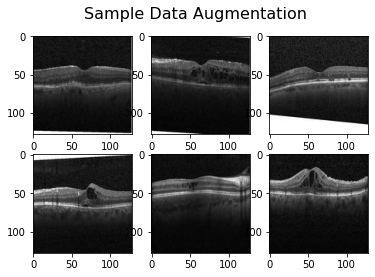

sample img, max value:  0.9294118
sample img, min value:  0.0


In [21]:
X_preview = train_generator2.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

### Trying to train the SRGAN model

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

def save_images(epoch, logs):
    # Generate a batch of images using the generator model
    batch_size = 32
    noise = np.random.normal(0, 1, (batch_size, 32, 32, 3))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2
    
    # Create the folder to save the generated images if it doesn't exist
    if not os.path.exists('generated_images_gray'):
        os.makedirs('generated_images_gray')
    
    # Save the images
    for i in range(batch_size):
        grayscale_image = rgb2gray(generated_images[i])
        plt.imsave(f"generated_images_gray/{epoch}_{i}.png", grayscale_image, cmap='gray')
    # for i in range(batch_size):
    #     plt.imsave(f"generated_images/{epoch}_{i}.png", generated_images[i])

from keras.callbacks import LambdaCallback

# Define the save_images callback
save_images_callback = LambdaCallback(on_epoch_end=save_images)

In [23]:
generator = build_generator((32, 32, 3))

In [24]:
srgan = build_SR_GAN((32, 32, 3))
srgan.compile(optimizer='adam', loss='mse')
srgan.fit(train_generator, epochs=100, callbacks=[save_images_callback])

Epoch 1/100
80/80 [==============================] - 38s 114ms/step - loss: 0.2690
Epoch 2/100
80/80 [==============================] - 6s 78ms/step - loss: 0.2481
Epoch 3/100
80/80 [==============================] - 7s 90ms/step - loss: 0.2468
Epoch 4/100
80/80 [==============================] - 6s 73ms/step - loss: 0.2452
Epoch 5/100
80/80 [==============================] - 7s 86ms/step - loss: 0.2440
Epoch 6/100
80/80 [==============================] - 6s 74ms/step - loss: 0.2430
Epoch 7/100
80/80 [==============================] - 6s 80ms/step - loss: 0.2442
Epoch 8/100
80/80 [==============================] - 6s 74ms/step - loss: 0.2423
Epoch 9/100
80/80 [==============================] - 7s 92ms/step - loss: 0.2422
Epoch 10/100
80/80 [==============================] - 6s 76ms/step - loss: 0.2415
Epoch 11/100
80/80 [==============================] - 7s 90ms/step - loss: 0.2422
Epoch 12/100
80/80 [==============================] - 6s 73ms/step - loss: 0.2422
Epoch 13/100
80/80 [===